In [1]:
from __future__ import print_function, division

import sys
import numpy as np
import thinkstats2

from collections import defaultdict

import pandas
import thinkplot
import analytic
import statsmodels.formula.api as smf

data = pandas.read_csv('Summer Olympic medals 1976 to 2008.csv', 
                       encoding = "ISO-8859-1",
                       keep_default_na=False, 
                       na_values=["","NaN","NA"]
                      )
df = pandas.DataFrame(data)

In [2]:
'''CLEANING THE DATA'''

# Remove null values; There are 117 rows that are null across all variables
df=df.dropna(axis=0, how='any')

#Convert 'Year' from float to int 
df['Year'] = df['Year'].astype('object',copy=False) 

In [3]:
'''CREATE NEW COLUMNS BASED ON CURRENT COLUMNS'''

#Create new column with Host Country based on the City column
conditions = [(df['City'] == 'Montreal'),
             (df['City'] == 'Moscow'),
             (df['City'] == 'Los Angeles'),
             (df['City'] == 'Seoul'),
             (df['City'] == 'Barcelona'),
             (df['City'] == 'Atlanta'),
             (df['City'] == 'Sydney'),
             (df['City'] == 'Athens'),
             (df['City'] == 'Beijing')]

#Mapping the city to the country. 
choices = ['Canada',
          'Russia',
          'United States',
          'Korea, South',
          'Spain',
          'United States',
          'Australia',
          'Greece', 
          'China']

df['Host_Country'] = np.select(conditions, choices, default = '0')

#Replace "Soviet Union" in the Country name with Russia
df['Country'] = df['Country'].replace(['Soviet Union'],'Russia')

#Replace "East Germany" in the Country name with Germany
df['Country'] = df['Country'].replace(['East Germany'],'Germany')

#Create a new column with 0/1 options based on if the host country won the medal
df["Host_Win"] = np.where(df['Host_Country'] == df['Country'], '1', '0')


#While East Germany and the Soviet Union were countries at the time of the Olympics in which they won medals,
#they have been updated to allow for correct statistical calculations

In [4]:
#Create dfs with just winners from the host country and just winners from countries not the host
Host_Winners = df[df.Host_Win == '1']
Other_Winners = df[df.Host_Win == '0']

In [5]:
#Create df with just host countries, regardless if they won that year
Host_Countries = df[df.Country.isin(['Canada',
          'Russia',
          'United States',
          'Korea, South',
          'Spain',
          'Australia',
          'Greece', 
          'China'])]

#Create df with the host country wins for every other year than the year they hosted
Host_Countries_Other = Host_Countries[Host_Countries.Host_Win == '0']

#Create df of all other countries that did not host
Other_Countries = df[-df.Country.isin(['Canada',
          'Russia',
          'United States',
          'Korea, South',
          'Spain',
          'Australia',
          'Greece', 
          'China'])]

In [6]:
#Create dfs for each medal 
Gold = df[df.Medal == 'Gold']
Silver = df[df.Medal == 'Silver']
Bronze = df[df.Medal == 'Bronze']

In [7]:
#Create df grouped by Country
Medal_Counts = df.groupby('Country', as_index = False).count()

In [8]:
#Create dfs of the host countries grouped by country, counting the number of medals when they were hosting vs. not
Hosting = Host_Winners.groupby(['Country'], as_index=False).count()
Not_Hosting = Host_Countries_Other.groupby(['Country'], as_index=False).count()

#Create a df of Host Countries from columns with medal counts from years they were hosting, not hosting, and the
#percentage of medals won while hosting
data = [Not_Hosting['Country'], Hosting['Medal'], Not_Hosting['Medal']]
headers = ["Country", "Hosting", "Not Hosting"]

df_both = pandas.concat(data, axis=1, keys=headers)

df_both['Percentage while Hosting'] = (df_both['Hosting']/(df_both['Hosting']+df_both['Not Hosting']))*100


In [9]:
#Create new df with number of medals won by each host country for each year. 
grouped = Host_Countries.groupby(['Year','Country'], as_index=False).count()

condensed_grouped = grouped[['Year', 'Country', 'Medal']]

In [10]:
#Create new column with Host Country based on the Year column
conditions = [(grouped['Year'] == 1976),
              (grouped['Year'] == 1980),
              (grouped['Year'] == 1984),
              (grouped['Year'] == 1988),
              (grouped['Year'] == 1992),
              (grouped['Year'] == 1996),
              (grouped['Year'] == 2000),
              (grouped['Year'] == 2004),
              (grouped['Year'] == 2008)]

#Mapping the city to the country. 
choices = ['Canada',
          'Russia',
          'United States',
          'Korea, South',
          'Spain',
          'United States',
          'Australia',
          'Greece', 
          'China']

grouped['Host_Country_New'] = np.select(conditions, choices, default = '0')

#Create a new column with 0/1 options based on if the host country won the medal
grouped["Host_Win_Bin"] = np.where(grouped['Host_Country_New'] == grouped['Country'], '1', '0')

In [11]:
#Create df to show how many of each type of medal the US won at each games
grouped2 = Host_Countries.groupby(['Medal','Country', 'Year'], as_index=False).count()
Country_grouped2 = grouped2[grouped2.Country == 'United States']
US_grouped2 = Country_grouped2[['Medal', 'Year', 'Sport']]

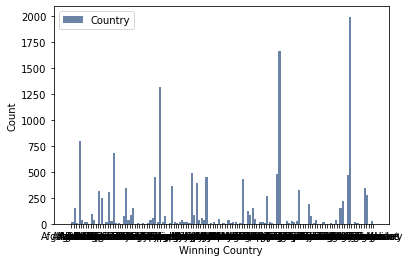

In [12]:
#Histogram of winners from all countries
hist_win = thinkstats2.Hist(df.Country, label='Country')
thinkplot.Hist(hist_win)
thinkplot.Config(xlabel='Winning Country', ylabel='Count')

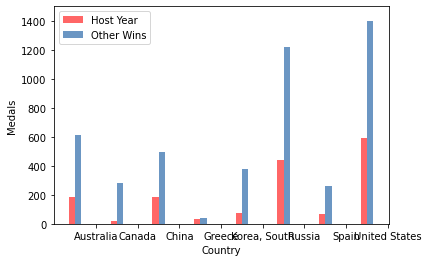

In [13]:
#Histogram of host countries when they won while hosting vs not hosting
host_hist = thinkstats2.Hist(Host_Winners.Country, label='Host Year')
other_hist = thinkstats2.Hist(Host_Countries_Other.Country, label='Other Wins')

width = 0.15
thinkplot.PrePlot(2)
thinkplot.Hist(host_hist, align='right', width=width, color = 'red')
thinkplot.Hist(other_hist, align='left', width=width)
thinkplot.Config(xlabel='Country', ylabel='Medals', ylim = (0,1500))

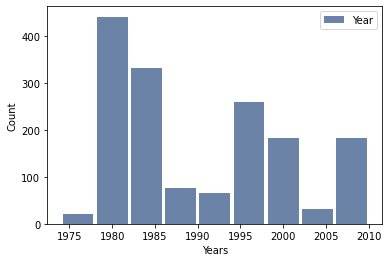

In [14]:
#Histogram of the years where the hosts won medals
hist_years = thinkstats2.Hist(Host_Winners.Year, label='Year')
thinkplot.Hist(hist_years)
thinkplot.Config(xlabel='Years', ylabel='Count')

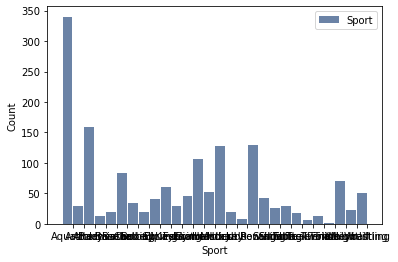

In [15]:
#Histogram of the sports in which winners represented the host country
hist_sport = thinkstats2.Hist(Host_Winners.Sport, label='Sport')
thinkplot.Hist(hist_sport)
thinkplot.Config(xlabel='Sport', ylabel='Count')

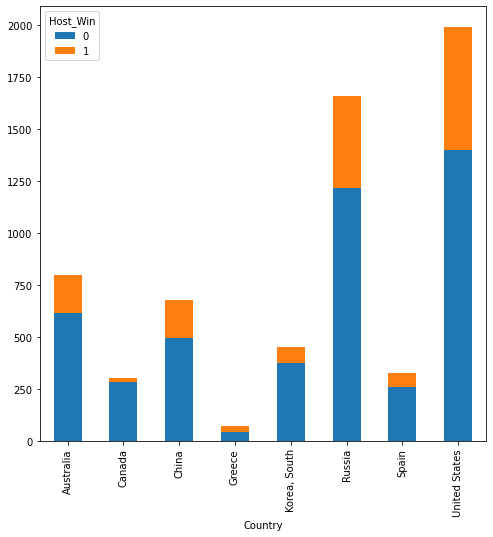

In [16]:
#Stacked Histogram showing the wins for host countries, when they did and didn't host
Country_HostWin_table = pandas.crosstab(index=Host_Countries["Country"], 
                          columns=Host_Countries["Host_Win"])

Country_HostWin_table.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=True)

In [17]:
#Descriptive Statistics
df.describe()

,City,Year,Sport,Discipline,Event,Athlete,Gender,Country_Code,Country,Event_gender,Medal,Host_Country,Host_Win
count,15316,15316.0,15316,15316,15316,15316,15316,15316,15316,15316,15316,15316,15316
unique,9,9.0,28,41,293,11337,2,128,125,3,3,8,2
top,Beijing,2008.0,Aquatics,Athletics,hockey,"PHELPS, Michael",Men,USA,United States,M,Bronze,United States,0
freq,2042,2042.0,2210,1523,817,16,9388,1992,1992,8817,5258,3318,13720


In [18]:
Host_Winners.describe()

,City,Year,Sport,Discipline,Event,Athlete,Gender,Country_Code,Country,Event_gender,Medal,Host_Country,Host_Win
count,1596,1596.0,1596,1596,1596,1596,1596,1596,1596,1596,1596,1596,1596
unique,9,9.0,28,40,204,1388,2,8,8,3,3,8,1
top,Moscow,1980.0,Aquatics,Swimming,hockey,"DITYATIN, Aleksandr",Men,USA,United States,M,Gold,United States,1
freq,442,442.0,340,218,128,8,889,593,593,811,734,593,1596


In [19]:
#Count how many times a host country won a medal
df.Host_Win.value_counts().sort_index()

0    13720
1     1596
Name: Host_Win, dtype: int64

In [20]:
#Find a percentage of medal winners that were from the host country
df.Host_Win.value_counts(normalize=True)

0    0.895795
1    0.104205
Name: Host_Win, dtype: float64

In [21]:
#Top 5 Medal Counts by Country
df.Country.value_counts().head(5)

United States    1992
Russia           1659
Germany          1317
Australia         798
China             679
Name: Country, dtype: int64

In [22]:
#Bottom 5 Medal Counts by Country
df.Country.value_counts().tail(5)

Virgin Islands*    1
Guyana             1
Senegal            1
Eritrea            1
Bermuda*           1
Name: Country, dtype: int64

In [23]:
#Medal Counts for all Countries
df.Country.value_counts()

United States      1992
Russia             1659
Germany            1317
Australia           798
China               679
                   ... 
Virgin Islands*       1
Guyana                1
Senegal               1
Eritrea               1
Bermuda*              1
Name: Country, Length: 125, dtype: int64

In [24]:
#Number of countries that have won a medal
df['Country'].nunique()

125

In [25]:
#How many countries won medals the same amount of times (i.e 11 Countries won 2 medals total)
Medal_Counts.Medal.value_counts()

1       22
2       11
3        6
14       5
21       4
        ..
388      1
1317     1
35       1
34       1
1659     1
Name: Medal, Length: 68, dtype: int64

In [26]:
#Count number of medals won while hosting
Host_Winners.Country.value_counts()

United States    593
Russia           442
China            184
Australia        183
Korea, South      77
Spain             66
Greece            31
Canada            20
Name: Country, dtype: int64

In [27]:
#Calculate Mean of Medals won by the hosting country and by all countries
HostMean = (Host_Winners.Country.value_counts().mean())
TotalMean = (df.Country.value_counts().mean())
print ("Mean of Medals won by the hosting country: ", HostMean) 
print ("Mean of Medals won by all countries: ", TotalMean)

Mean of Medals won by the hosting country:  199.5
Mean of Medals won by all countries:  122.528


In [28]:
#Calculate Standard Deviation of Medals won by the hosting country and by all countries
HostStd = (Host_Winners.Country.value_counts().std())
TotalStd = (df.Country.value_counts().std())
print ("Standard Deviation of Medals won by the hosting country: ", HostStd) 
print ("Standard Deviation of Medals won by all countries: ", TotalStd)

Standard Deviation of Medals won by the hosting country:  209.62619792655414
Standard Deviation of Medals won by all countries:  287.72325345832775


In [29]:
#Calculate Variation of Medals won by the hosting country and by all countries
HostVar = (Host_Winners.Country.value_counts().var())
TotalVar = (df.Country.value_counts().var())
print ("Variation of Medals won by the hosting country: ", HostVar) 
print ("Variation of Medals won by all countries: ", TotalVar)

Variation of Medals won by the hosting country:  43943.142857142855
Variation of Medals won by all countries:  82784.67058064512


In [30]:
#Percentage of events each sport makes up of the games
df.Sport.value_counts(normalize=True).head(5)

Aquatics      0.144294
Athletics     0.099438
Rowing        0.089906
Hockey        0.053343
Gymnastics    0.051123
Name: Sport, dtype: float64

In [31]:
#Percentage of Host Winners per Sport
Host_Winners.Sport.value_counts(normalize=True).head(5)

Aquatics      0.213033
Athletics     0.099624
Rowing        0.080827
Hockey        0.080201
Gymnastics    0.066416
Name: Sport, dtype: float64

In [32]:
#Percentage of Host Winners per Year
Host_Winners.Year.value_counts(normalize=True)

1980.0    0.276942
1984.0    0.208647
1996.0    0.162907
2008.0    0.115288
2000.0    0.114662
1988.0    0.048246
1992.0    0.041353
2004.0    0.019424
1976.0    0.012531
Name: Year, dtype: float64

In [33]:
#Percentage each host country has won
Host_Winners.Country.value_counts(normalize=True)

United States    0.371554
Russia           0.276942
China            0.115288
Australia        0.114662
Korea, South     0.048246
Spain            0.041353
Greece           0.019424
Canada           0.012531
Name: Country, dtype: float64

In [40]:
#Create a probability mass function of the likelihood of the which host country would have won
n_host = hist_host.Total()
pmf_host = hist_host.Copy()
for x, freq in hist_host.Items():
    pmf_host[x] = freq / n_host
    
thinkplot.Hist(pmf_host, align = 'left')
thinkplot.Config(xlabel='Winning Country', ylabel='PMF')

NameError: name 'hist_host' is not defined

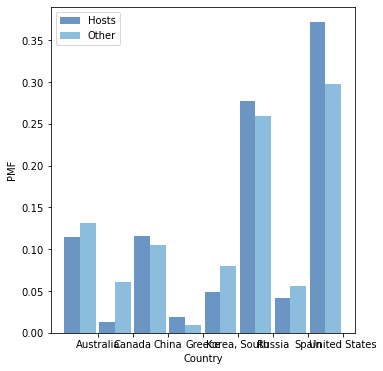

In [41]:
#PMF of the host countries when they won while hosting vs when they won while not hosting 
Host_pmf = thinkstats2.Pmf(Host_Winners.Country, label='Hosts')
Other_pmf = thinkstats2.Pmf(Host_Countries_Other.Country, label='Other')

width=0.45
thinkplot.PrePlot(2, cols=2)
thinkplot.Hist(Host_pmf, align='right', width=width)
thinkplot.Hist(Other_pmf, align='left', width=width)
thinkplot.Config(xlabel='Country', ylabel='PMF')


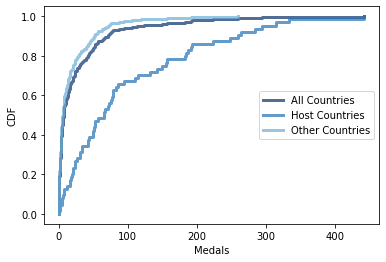

In [42]:
#CDF of number of medals won by all of the countries. This indicates that 
total_grouped = df.groupby(['Year','Country'], as_index=False).count()
others_grouped = Other_Countries.groupby(['Year','Country'], as_index=False).count()

cdf_total = thinkstats2.Cdf(total_grouped.Medal, label='All Countries')
cdf_hosts = thinkstats2.Cdf(condensed_grouped.Medal, label='Host Countries')
cdf_others = thinkstats2.Cdf(others_grouped.Medal, label='Other Countries')

thinkplot.PrePlot(3)
thinkplot.Cdfs([cdf_total, cdf_hosts, cdf_others])
thinkplot.Config(xlabel='Medals', ylabel='CDF', loc='center right', legend = True)

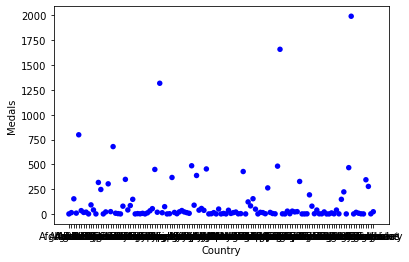

In [43]:
thinkplot.Scatter('Country', 'Medal', data = Medal_Counts, alpha=1.0)

thinkplot.Config(xlabel='Country',
                 ylabel='Medals',
                 legend = False)

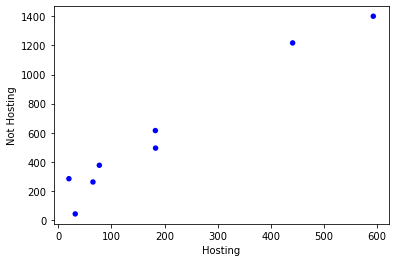

In [44]:
Hosting, Not_Hosting = df_both['Hosting'], df_both['Not Hosting']

Hosting = thinkstats2.Jitter(Hosting)
Not_Hosting = thinkstats2.Jitter(Not_Hosting)

thinkplot.Scatter(Hosting, Not_Hosting, alpha=1.0)

thinkplot.Config(xlabel='Hosting',
                 ylabel='Not Hosting',
                 legend = False)

In [45]:
def Cov(xs, ys, meanx=None, meany=None):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)

    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

Cov(Hosting, Not_Hosting)

85974.20043526741

In [46]:
def Corr(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    meanx, varx = thinkstats2.MeanVar(xs)
    meany, vary = thinkstats2.MeanVar(ys)

    corr = Cov(xs, ys, meanx, meany) / np.sqrt(varx * vary)
    return corr

Corr(Hosting, Not_Hosting)

0.9801637425579175

In [47]:
def SpearmanCorr(xs, ys):
    xs = pandas.Series(xs)
    ys = pandas.Series(ys)
    return xs.corr(ys, method='spearman')

SpearmanCorr(Hosting, Not_Hosting)

0.9047619047619048

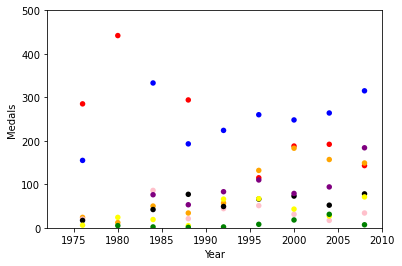

In [57]:
#Scatterplot with years as the Y axis, medals won as x-axis, color coded by country
Russia = condensed_grouped[condensed_grouped.Country == 'Russia']
Australia = condensed_grouped[condensed_grouped.Country == 'Australia']
Canada = condensed_grouped[condensed_grouped.Country == 'Canada']
SKorea = condensed_grouped[condensed_grouped.Country == 'Korea, South']
Spain = condensed_grouped[condensed_grouped.Country == 'Spain']
US = condensed_grouped[condensed_grouped.Country == 'United States']
Greece = condensed_grouped[condensed_grouped.Country == 'Greece']
China = condensed_grouped[condensed_grouped.Country == 'China']

thinkplot.PrePlot(8)
thinkplot.Scatter('Year', 'Medal', data = Russia, alpha=1.0, color = 'red', label = 'Russia')
thinkplot.Scatter('Year', 'Medal', data = Australia, alpha=1.0, color = 'orange', label = 'Australia')
thinkplot.Scatter('Year', 'Medal', data = Canada, alpha=1.0, color = 'pink', label = 'Canada')
thinkplot.Scatter('Year', 'Medal', data = SKorea, alpha=1.0, color = 'black', label = 'South Korea')
thinkplot.Scatter('Year', 'Medal', data = Spain, alpha=1.0, color = 'yellow', label = 'Spain')
thinkplot.Scatter('Year', 'Medal', data = US, alpha=1.0, color = 'blue', label = 'United States')
thinkplot.Scatter('Year', 'Medal', data = Greece, alpha=1.0, color = 'green', label = 'Greece')
thinkplot.Scatter('Year', 'Medal', data = China, alpha=1.0, color = 'purple', label = 'China')

thinkplot.Config(xlabel='Year',
                 ylabel='Medals',
                 axis=[1972, 2010, 0, 500],
                 legend = False)


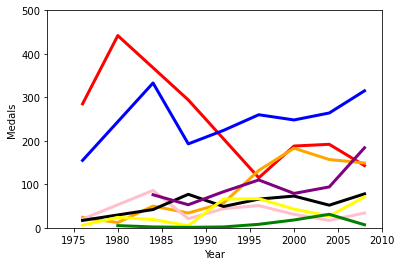

In [56]:
#Line graph with x axis as the year, y axis as number of medals, and different colored lines for each host country

thinkplot.PrePlot(8)
thinkplot.Plot('Year', 'Medal', data = Russia, alpha=1.0, color = 'red')
thinkplot.Plot('Year', 'Medal', data = Australia, alpha=1.0, color = 'orange')
thinkplot.Plot('Year', 'Medal', data = Canada, alpha=1.0, color = 'pink')
thinkplot.Plot('Year', 'Medal', data = SKorea, alpha=1.0, color = 'black')
thinkplot.Plot('Year', 'Medal', data = Spain, alpha=1.0, color = 'yellow')
thinkplot.Plot('Year', 'Medal', data = US, alpha=1.0, color = 'blue')
thinkplot.Plot('Year', 'Medal', data = Greece, alpha=1.0, color = 'green')
thinkplot.Plot('Year', 'Medal', data = China, alpha=1.0, color = 'purple')

thinkplot.Config(xlabel='Year',
                 ylabel='Medals',
                 axis=[1972, 2010, 0, 500],
                 legend=True)

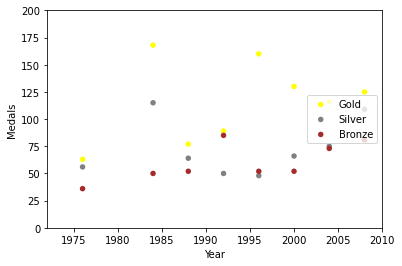

In [50]:
Gold = US_grouped2[US_grouped2.Medal == 'Gold']
Silver = US_grouped2[US_grouped2.Medal == 'Silver']
Bronze = US_grouped2[US_grouped2.Medal == 'Bronze']

thinkplot.PrePlot(3)
thinkplot.Scatter('Year', 'Sport', data = Gold, alpha=1.0, color = 'yellow', label = 'Gold')
thinkplot.Scatter('Year', 'Sport', data = Silver, alpha=1.0, color = 'grey', label = 'Silver')
thinkplot.Scatter('Year', 'Sport', data = Bronze, alpha=1.0, color = 'brown', label = 'Bronze')

thinkplot.Config(xlabel='Year',
                 ylabel='Medals',
                 axis=[1972, 2010, 0, 200],
                 legend=True)

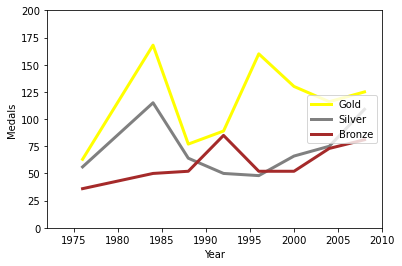

In [51]:
thinkplot.PrePlot(3)
thinkplot.Plot('Year', 'Sport', data = Gold, alpha=1.0, color = 'yellow', label = 'Gold')
thinkplot.Plot('Year', 'Sport', data = Silver, alpha=1.0, color = 'grey', label = 'Silver')
thinkplot.Plot('Year', 'Sport', data = Bronze, alpha=1.0, color = 'brown', label = 'Bronze')

thinkplot.Config(xlabel='Year',
                 ylabel='Medals',
                 axis=[1972, 2010, 0, 200],
                 legend=True)

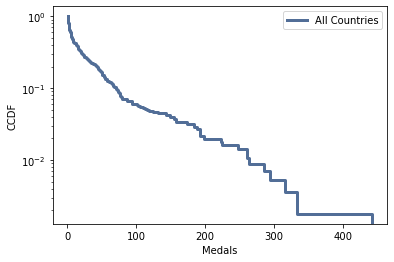

In [52]:
#Exponential Distribution of the medals won for All Countries
thinkplot.Cdf(cdf_total, complement=True)
thinkplot.Config(xlabel='Medals',
                 ylabel='CCDF', yscale='log', loc='upper right')

In [53]:
#Assign the Dependent and Explanatory variables for simple regression
Dependent = grouped.Medal
Explanatory = grouped.Host_Win_Bin

In [54]:
#Calculate simple regression 
formula = 'Medal ~ Host_Win_Bin'
model = smf.ols(formula, data=grouped)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Medal   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     7.373
Date:                Sat, 21 Nov 2020   Prob (F-statistic):            0.00857
Time:                        15:58:01   Log-Likelihood:                -380.74
No. Observations:                  64   AIC:                             765.5
Df Residuals:                      62   BIC:                             769.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            85.3091     12.709      6.712      0.000      59.904     110.715
Host_Win_Bin[T.1]    92.0242     33.891      2.715      0.009      24.276     159.772
==============================================================================
Omnibus:                       11.267   Durbin-Watson:                   2.322
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.729
Skew:                           1.027   Prob(JB):                      0.00284
Kurtosis:                       3.426   Cond. No.                         2.94
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""